<a href="https://colab.research.google.com/github/Tokisaki-Galaxy/PterygiumSeg/blob/master/work2_basemode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 翼状胬肉区域分割模型

这是项目的第二个任务：实现对眼部裂隙灯检查图片中翼状胬肉区域的精准分割。我们将使用U-Net模型解决这一问题。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
from torchvision import transforms, models
from torchvision.transforms import functional as F
import torch.nn.functional
import pandas as pd
import os
import shutil
import numpy as np
from PIL import Image
import zipfile
import sys
import platform
import random
import time
import glob
from tqdm.autonotebook import tqdm # 好看！
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.measure import label
import matplotlib.font_manager

if platform.system() == "Windows":
    num_workers = 0
    print(f"检测到 Windows 系统，将 DataLoader 的 num_workers 设置为 {num_workers}。")
else:
    # 在非 Windows 系统（如 Linux/Colab）上
    num_workers = 4
    print(f"检测到非 Windows 系统 ({platform.system()})，将 DataLoader 的 num_workers 设置为 {num_workers}。")
    # 设置中文字体
    if not os.path.exists('simhei.ttf'):
        !wget -O simhei.ttf "https://cdn.jsdelivr.net/gh/Haixing-Hu/latex-chinese-fonts/chinese/%E9%BB%91%E4%BD%93/SimHei.ttf"
    matplotlib.font_manager.fontManager.addfont('simhei.ttf')
    matplotlib.rc('font', family='SimHei')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

patch_size = 512  # 定义 patch 大小
patch_stride = patch_size // 2 # 定义训练时的步长（产生50%重叠）
predict_stride = patch_size // 2 # 定义预测时的步长（产生50%重叠）
target_input_size = (patch_size, patch_size) # U-Net的输入尺寸应为 patch_size

# ================== 数据集路径 =================
# 数据路径
image_dir =          r"f:/train"
# colab路径
colab_zip_path = "/content/drive/My Drive/train.zip"
colab_extract_path = "/content/trains/"
# Kaggle路径
kaggle_extract_path = "/kaggle/input/pterygium/train/"
kaggle_temp_path = "/kaggle/working/"

# =================== 验证集路径 =================
# 验证集路径
val_image_dir =      r"f:/val"
# colab路径
# Kaggle路径
kaggle_val_path = "/kaggle/input/pterygium/val_img/"

# ================== 掩码输出路径 ================
output_mask_dir = r"f:/mask"
# colab路径
output_maskfiles_colab = "/content/mask"
# Kaggle路径
output_maskfiles_kaggle = "/kaggle/working/mask"

# 配置GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA 可用: {torch.cuda.is_available()}")
print(f"使用的设备: {device}")

if torch.cuda.is_available():
    cudnn.benchmark = True
    print("cuDNN benchmark 模式已启用")

/tmp/ipykernel_19/3097202062.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm # 好看！


检测到非 Windows 系统 (Linux)，将 DataLoader 的 num_workers 设置为 4。
--2025-04-13 03:33:35--  https://cdn.jsdelivr.net/gh/Haixing-Hu/latex-chinese-fonts/chinese/%E9%BB%91%E4%BD%93/SimHei.ttf
Resolving cdn.jsdelivr.net (cdn.jsdelivr.net)... 151.101.65.229, 151.101.193.229, 151.101.1.229, ...
Connecting to cdn.jsdelivr.net (cdn.jsdelivr.net)|151.101.65.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [font/ttf]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.30M  --.-KB/s    in 0.1s    

2025-04-13 03:33:36 (91.0 MB/s) - ‘simhei.ttf’ saved [9751960/9751960]

CUDA 可用: True
使用的设备: cuda
cuDNN benchmark 模式已启用


# 读取和准备数据
我们需要读取原始图像和对应的分割标签（mask）。标签中像素值为128的区域表示翼状胬肉，像素值为0的区域表示背景。

In [2]:
# 如果在云端上运行，从 Google Drive 读取数据
if 'google.colab' in sys.modules or os.path.exists("/kaggle/working"):

    if 'google.colab' in sys.modules:
        print('在 Google Colab 环境中运行')
        image_dir = os.path.join(colab_extract_path,"train")
        label_file = os.path.join(image_dir,"train_classification_label.xlsx")
        zip_path = colab_zip_path
        extract_path = colab_extract_path
        BASE_PATCH_DIR = "/content/train_patches_gpu"

        output_mask_dir = output_maskfiles_colab
        print(f"Colab 环境：验证结果将验证压缩 {output_mask_dir} 到 {output_mask_dir}.zip")

        # Mount Google Drive
        from google.colab import drive
        drive.mount('/content/drive')
    else:
        print('在 Kaggle 环境中运行')
        image_dir = os.path.join(kaggle_extract_path,"train")
        label_file = os.path.join(image_dir,"train_classification_label.xlsx")
        val_image_dir = os.path.join(kaggle_val_path,"val_img")
        BASE_PATCH_DIR = "/kaggle/working/train_patches_gpu"
        
        output_mask_dir = output_maskfiles_kaggle
        print(f"Kaggle 环境：验证结果将压缩 {output_mask_dir} 到 {output_mask_dir}.zip")

    if not os.path.exists(label_file):
        # 解压数据
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)    
else:
    print(f'不在云端环境中运行,使用本地数据路径{image_dir}')
    BASE_PATCH_DIR = "data/train_patches_gpu"
label_file = os.path.join(image_dir,"train_classification_label.xlsx")

# 自定义数据集类，用于读取图像和分割掩码
class PterygiumSegmentationDataset(Dataset):
    def __init__(self, label_file, image_dir, transform=None, mask_transform=None):
        """
        初始化数据集
        :param label_file: 包含图像标签的Excel文件路径
        :param image_dir: 图像文件夹路径
        :param transform: 图像变换操作
        :param mask_transform: 掩码变换操作
        """
        self.labels_df = pd.read_excel(label_file)
        # 只保留翼状胬肉样本（标签1和2）
        self.labels_df = self.labels_df[self.labels_df['Pterygium'] > 0].reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        获取指定索引的图像和分割掩码
        :param idx: 索引
        :return: 图像张量和对应掩码张量
        """
        row = self.labels_df.iloc[idx]
        image_name = row['Image']
        label = row['Pterygium']
        image_folder = f"{int(image_name):04d}"
        
        # 加载图像
        image_path = os.path.join(self.image_dir, image_folder, f"{image_folder}.png")
        image = Image.open(image_path).convert("RGB")
        
        # 加载分割掩码
        mask_path = os.path.join(self.image_dir, image_folder, f"{image_folder}_label.png")
        mask = Image.open(mask_path).convert("RGB")  # 转换为灰度图
        
        # 应用图像变换
        if self.transform:
            image = self.transform(image)
            
        # 应用掩码变换
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            # 将掩码转换为张量，并二值化（翼状胬肉区域为1，背景为0）
            mask = torch.from_numpy(np.array(mask))
            mask = mask.float() / 255.0
            mask = (mask > 0.2).float()  # 二值化，阈值设为0.2以捕获可能的淡色区域
        
        return image, mask

在 Kaggle 环境中运行
Kaggle 环境：验证结果将压缩 /kaggle/working/mask 到 /kaggle/working/mask.zip


# 离线Patching函数 (利用GPU加速)
用于将原始的大尺寸图像和对应的分割掩码离线切割成指定大小的Patches，并保存到磁盘。
该函数会尝试将大图加载到GPU进行裁剪和过滤，以加速处理过程（需要注意GPU显存）。

In [3]:
# --- 配置参数 ---
MIN_FOREGROUND_RATIO = 0.01 # (可选) 保留的Mask Patch中前景像素(128)最小比例，设为0则不过滤

# --- 离线 Patching 函数 ---
def create_offline_patches_gpu(
    input_image_dir,
    label_file_path,
    output_image_patch_dir,
    output_mask_patch_dir, # 如果为 None，则只处理图像 Patch
    patch_size,
    stride,
    device,
    min_foreground_ratio=0.01
    ):
    """
    离线创建图像和掩码的Patches，尝试使用GPU加速，并根据标签文件筛选图像。

    Args:
        input_image_dir (str): 包含原始图像子文件夹 (如 0001, 0002...) 的目录。
        label_file_path (str): 包含图像标签的Excel文件路径。
        output_image_patch_dir (str): 保存图像Patch的目录。
        output_mask_patch_dir (str or None): 保存掩码Patch的目录。如果为 None，则不处理或保存掩码。
        patch_size (int): Patch的边长。
        stride (int): 切割Patch时的步长。
        device (torch.device): 用于计算的设备 (cuda or cpu)。
        min_foreground_ratio (float): 保留的Mask Patch中前景像素(值>0)的最小比例。设为0则不过滤。

    Returns:
        tuple: (成功处理的大图数量, 创建的Patch对数量)
    """
    start_time = time.time()
    try:
        os.makedirs(output_image_patch_dir, exist_ok=True)
        if output_mask_patch_dir:
            os.makedirs(output_mask_patch_dir, exist_ok=True)
    except Exception as e:
        print(f"创建输出目录时出错: {e}")
        # 允许在 output_mask_patch_dir 为 None 时继续

    # 读取并筛选标签文件
    try:
        labels_df = pd.read_excel(label_file_path)
        # 只保留翼状胬肉样本（标签1和2）
        pterygium_df = labels_df[labels_df['Pterygium'] > 0].reset_index(drop=True)
        # 获取需要处理的图像文件夹名称列表 (格式化为 0001, 0002 ...)
        image_folders_to_process = pterygium_df['Image'].astype(int).apply(lambda x: f"{x:04d}").tolist()
        print(f"从 {os.path.basename(label_file_path)} 读取标签，找到 {len(image_folders_to_process)} 个翼状胬肉样本进行Patching。")
    except FileNotFoundError:
        print(f"错误: 标签文件未找到 {label_file_path}。无法进行Patching。")
        return 0, 0
    except Exception as e:
        print(f"读取或处理标签文件 {label_file_path} 时出错: {e}")
        return 0, 0

    processed_files = 0
    created_patches = 0

    for folder_name in tqdm(image_folders_to_process, desc="处理带标签的大图"):
        image_path = os.path.join(input_image_dir, folder_name, f"{folder_name}.png")
        mask_path = os.path.join(input_image_dir, folder_name, f"{folder_name}_label.png")

        # 检查图像文件是否存在
        if not os.path.exists(image_path):
            print(f"警告: 图像文件未找到 {image_path}，跳过文件夹 {folder_name}。")
            continue

        # 仅在需要处理掩码时检查掩码文件
        if output_mask_patch_dir and not os.path.exists(mask_path):
            print(f"警告: 掩码文件未找到 {mask_path} (但需要处理掩码)，跳过文件夹 {folder_name}。")
            continue
        elif not output_mask_patch_dir:
            # 如果不需要处理掩码，即使掩码不存在也继续（只生成图像patch）
            mask_path = None # 明确设置为 None

        try:
            # 1. 加载大图 (CPU)
            img_pil = Image.open(image_path).convert('RGB')
            img_w, img_h = img_pil.size
            mask_pil = None
            mask_tensor_gpu = None # 初始化

            # 仅在需要时加载和处理掩码
            if mask_path:
                mask_pil = Image.open(mask_path).convert('RGB')
                mask_w, mask_h = mask_pil.size
                if img_w != mask_w or img_h != mask_h:
                    print(f"警告: 图像和掩码尺寸不匹配 {folder_name}，跳过。 ({img_w}x{img_h} vs {mask_w}x{mask_h})")
                    continue

            # 2. 转换为Tensor并移至GPU (如果显存允许)
            try:
                img_tensor_gpu = F.to_tensor(img_pil).to(device) # (3, H, W)
                if mask_pil:
                    # 将Mask转换为0/1 Tensor，再移到GPU
                    mask_np_rgb = np.array(mask_pil)
                    mask_binary = (mask_np_rgb[:, :, 0] == 128).astype(np.float32) # 前景 = 1 if R == 128
                    mask_tensor_gpu = torch.from_numpy(mask_binary).unsqueeze(0).to(device) # (1, H, W)

            except RuntimeError as e:
                print(f"\n错误: 将图像/掩码 {folder_name} 移至GPU时出错 (可能显存不足): {e}")
                print("尝试在CPU上处理此图像...")
                device_fallback = torch.device("cpu")
                img_tensor_gpu = F.to_tensor(img_pil).to(device_fallback)
                if mask_pil:
                    mask_np_rgb = np.array(mask_pil)
                    mask_binary = (mask_np_rgb[:, :, 0] == 128).astype(np.float32)
                    mask_tensor_gpu = torch.from_numpy(mask_binary).unsqueeze(0).to(device_fallback)

            # 3. 在GPU上进行Patch裁剪和过滤
            patch_count_for_image = 0
            for y in range(0, img_h - patch_size + 1, stride):
                for x in range(0, img_w - patch_size + 1, stride):
                    # 在GPU上裁剪图像
                    img_patch_gpu = img_tensor_gpu[:, y:y+patch_size, x:x+patch_size]
                    mask_patch_gpu = None # 初始化

                    # 仅在需要时裁剪掩码
                    if mask_tensor_gpu is not None:
                        mask_patch_gpu = mask_tensor_gpu[:, y:y+patch_size, x:x+patch_size]

                        # 可选：在GPU上过滤 (基于前景比例) - 仅在有掩码时进行
                        if min_foreground_ratio > 0:
                            foreground_ratio = torch.mean(mask_patch_gpu) # mask是0/1，均值即比例
                            if foreground_ratio < min_foreground_ratio:
                                continue # 跳过前景过少的Patch

                    # 4. 将需要保存的Patch移回CPU
                    img_patch_cpu = img_patch_gpu.cpu()
                    mask_patch_cpu = None
                    if mask_patch_gpu is not None:
                        mask_patch_cpu = mask_patch_gpu.cpu() # 仍然是 0/1

                    # 5. 转换回PIL Image并保存 (CPU)
                    img_patch_pil = F.to_pil_image(img_patch_cpu)

                    # 生成保存文件名
                    patch_filename = f"{folder_name}_y{y}_x{x}.png"
                    img_save_path = os.path.join(output_image_patch_dir, patch_filename)
                    img_patch_pil.save(img_save_path)

                    # 仅在需要时保存掩码 Patch
                    if output_mask_patch_dir and mask_patch_cpu is not None:
                        # 将 0/1 的 mask tensor 转换回 0/128 的 PIL 灰度图
                        mask_patch_np = (mask_patch_cpu.squeeze().numpy() * 128).astype(np.uint8)
                        # 保存为 RGB 格式 (128,0,0) 以匹配原始格式
                        mask_patch_pil_rgb = Image.new("RGB", (patch_size, patch_size))
                        # 创建一个与mask_patch_np形状相同，但值为0的数组
                        zeros_channel = np.zeros_like(mask_patch_np)
                        # 堆叠通道 R=mask, G=0, B=0
                        mask_rgb_array = np.stack((mask_patch_np, zeros_channel, zeros_channel), axis=-1)
                        mask_patch_pil = Image.fromarray(mask_rgb_array, mode='RGB')

                        mask_save_path = os.path.join(output_mask_patch_dir, patch_filename)
                        mask_patch_pil.save(mask_save_path)

                    created_patches += 1
                    patch_count_for_image += 1

            # 6. 清理GPU内存中的大Tensor (重要!)
            del img_tensor_gpu
            if mask_tensor_gpu is not None: del mask_tensor_gpu
            if 'img_patch_gpu' in locals(): del img_patch_gpu
            if 'mask_patch_gpu' in locals() and mask_patch_gpu is not None: del mask_patch_gpu
            if device == torch.device("cuda"):
                torch.cuda.empty_cache() # 释放缓存

            processed_files += 1

        except Exception as e:
            print(f"\n处理文件 {folder_name} 时发生未预料错误: {e}")
            if device == torch.device("cuda"):
                torch.cuda.empty_cache()

    end_time = time.time()
    print("-" * 30)
    print("离线Patching完成！")
    print(f"成功处理（基于标签过滤后）大图数量: {processed_files} / {len(image_folders_to_process)}")
    print(f"总共创建Patch数量: {created_patches}") # 注意：如果是图像+掩码对，这是一个对数
    print(f"总耗时: {end_time - start_time:.2f} 秒")
    print("-" * 30)

    return processed_files, created_patches

def get_folder_size(folder_path):
    """计算文件夹的总大小（字节）"""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size


# 执行离线Patching
调用函数开始处理
如果输出目录已存在且包含文件，你可能想先清空或跳过

In [4]:
# --- 路径设置 ---
if os.path.exists("/kaggle/input/pterygium/train/"):
    INPUT_IMAGE_DIR = "/kaggle/input/pterygium/train/train" # 包含0001, 0002等子文件夹
    OUTPUT_PATCH_DIR = "/kaggle/working/train_patches"
elif 'google.colab' in sys.modules:
    INPUT_IMAGE_DIR = "/content/trains/train" # 解压后的路径
    OUTPUT_PATCH_DIR = "/content/train_patches"
elif os.name == 'nt':
    INPUT_IMAGE_DIR = "f:/train/train" # 包含0001, 0002等子文件夹
    OUTPUT_PATCH_DIR = "f:/train_patches"
else:
    assert False, "根据你的环境修改输入和输出路径"
    INPUT_IMAGE_DIR = "data/train/train"
    OUTPUT_PATCH_DIR = "data/train_patches"

OUTPUT_IMAGE_PATCH_DIR = os.path.join(OUTPUT_PATCH_DIR, "images")
OUTPUT_MASK_PATCH_DIR = os.path.join(OUTPUT_PATCH_DIR, "masks")

print(f"使用设备: {device}")
print(f"输入图像目录: {INPUT_IMAGE_DIR}")
print(f"输出 Patch 目录: {OUTPUT_PATCH_DIR}")
print(f"Patch 大小: {patch_size}x{patch_size}")
print(f"步长: {patch_stride}")
print(f"最小前景比例阈值: {MIN_FOREGROUND_RATIO}")

run_patching = True
patch_count = 0
# 检查输出目录是否存在
if os.path.exists(OUTPUT_PATCH_DIR):
    print(f"警告：输出 Patch 目录 {OUTPUT_PATCH_DIR} 已存在。")
    try:
        # 计算文件夹大小 (GB)
        folder_size_gb = get_folder_size(OUTPUT_PATCH_DIR) / (1024**3)
        print(f"目录大小约为 {folder_size_gb:.2f} GB。")

        # 检查大小是否超过阈值
        if folder_size_gb > 3.0:
            print("目录大小超过 3GB，认为缓存有效，将跳过 Patching 步骤。")
            run_patching = False # 不需要执行 Patching
            # 尝试统计现有 patches 数量，以备后续使用
            try:
                existing_patches = glob.glob(os.path.join(OUTPUT_IMAGE_PATCH_DIR, "*.png"))
                patch_count = len(existing_patches)
                print(f"使用缓存目录中的 {patch_count} 个现有 patches。")
            except Exception as e:
                print(f"无法统计缓存目录中的文件，将 patch_count 设为 0。错误: {e}")
                patch_count = 0
        else:
            print("目录大小未达 3GB，缓存文件不完整或过小。将删除旧缓存并重新生成。")
            shutil.rmtree(OUTPUT_PATCH_DIR)
    except Exception as e:
        print(f"检查目录大小或删除目录时出错: {e}。将尝试重新生成 Patch。")
        try:
            if os.path.exists(OUTPUT_PATCH_DIR):
                shutil.rmtree(OUTPUT_PATCH_DIR)
        except Exception as del_e:
            print(f"删除目录 {OUTPUT_PATCH_DIR} 时再次出错: {del_e}")
else:
    print(f"输出 Patch 目录 {OUTPUT_PATCH_DIR} 不存在，将创建并执行 Patching。")

if run_patching:
    print(f"\n准备执行离线 Patching，确保输出目录 {OUTPUT_PATCH_DIR} 及其子目录存在...")
    # 确保目标目录存在 (create_offline_patches_gpu 内部也会创建子目录)
    # 但在这里创建父目录是个好习惯
    os.makedirs(OUTPUT_PATCH_DIR, exist_ok=True)
    # 如果之前删除了，子目录 image/mask 需要在函数内创建

    print("\n开始执行离线 Patching...")
    processed_count, patch_count = create_offline_patches_gpu(
        input_image_dir=INPUT_IMAGE_DIR,
        label_file_path=label_file,             # 传入标签文件
        output_image_patch_dir=OUTPUT_IMAGE_PATCH_DIR, # 函数内部会创建 images 子目录
        output_mask_patch_dir=OUTPUT_MASK_PATCH_DIR,   # 函数内部会创建 masks 子目录
        patch_size=patch_size,
        stride=patch_stride,                    # 使用训练步长
        device=device,
        min_foreground_ratio=MIN_FOREGROUND_RATIO
    )
else:
    print("\nPatching 步骤已跳过（使用有效缓存）。")

使用设备: cuda
输入图像目录: /kaggle/input/pterygium/train/train
输出 Patch 目录: /kaggle/working/train_patches
Patch 大小: 512x512
步长: 256
最小前景比例阈值: 0.01
输出 Patch 目录 /kaggle/working/train_patches 不存在，将创建并执行 Patching。

准备执行离线 Patching，确保输出目录 /kaggle/working/train_patches 及其子目录存在...

开始执行离线 Patching...
从 train_classification_label.xlsx 读取标签，找到 300 个翼状胬肉样本进行Patching。


处理带标签的大图:   0%|          | 0/300 [00:00<?, ?it/s]

------------------------------
离线Patching完成！
成功处理（基于标签过滤后）大图数量: 300 / 300
总共创建Patch数量: 21560
总耗时: 2099.09 秒
------------------------------


# 验证生成的Patches
随机抽查几个生成的图像和掩码Patch，确保它们是对应的并且格式正确。


随机抽查 5 个生成的Patch对...


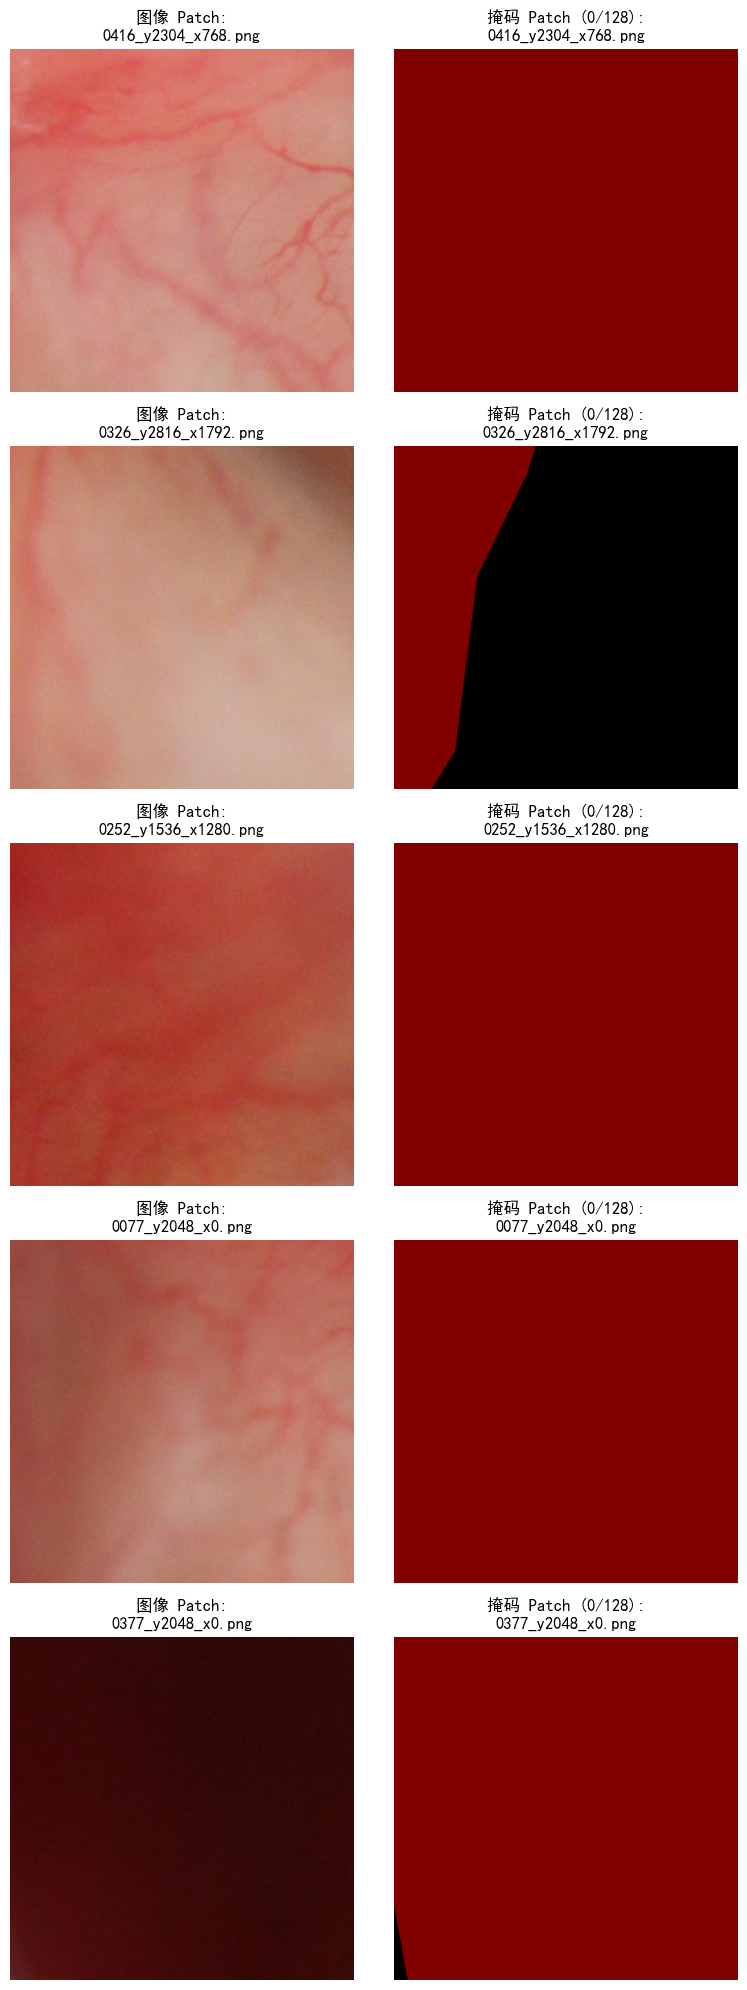

In [5]:
def verify_patches(image_patch_dir, mask_patch_dir, num_samples=5):
    image_patches = glob.glob(os.path.join(image_patch_dir, "*.png"))
    if not image_patches:
        print("错误: 找不到生成的图像Patches。")
        return

    print(f"\n随机抽查 {num_samples} 个生成的Patch对...")
    random_samples = random.sample(image_patches, min(num_samples, len(image_patches)))

    fig, axes = plt.subplots(len(random_samples), 2, figsize=(8, 4 * len(random_samples)))
    if len(random_samples) == 1: # 处理只有一个样本的情况
        axes = axes.reshape(1, 2)

    for i, img_path in enumerate(random_samples):
        base_name = os.path.basename(img_path)
        mask_path = os.path.join(mask_patch_dir, base_name)

        if not os.path.exists(mask_path):
            print(f"错误: 找不到对应的掩码Patch {mask_path}")
            continue

        img_patch = Image.open(img_path)
        mask_patch = Image.open(mask_path)

        axes[i, 0].imshow(img_patch)
        axes[i, 0].set_title(f"图像 Patch:\n{base_name}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_patch, cmap='gray')
        axes[i, 1].set_title(f"掩码 Patch (0/128):\n{base_name}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# 执行验证
try:
    verify_patches(OUTPUT_IMAGE_PATCH_DIR, OUTPUT_MASK_PATCH_DIR, num_samples=5)
except:
    print("未生成任何Patch，跳过验证。")

# 创建数据加载器
设置训练和验证数据加载器，包括数据增强策略。

In [6]:
class PterygiumSegDataset(Dataset):
    def __init__(self, image_patch_dir, mask_patch_dir, file_list=None, augment=True):
            """
            初始化数据集 (加载离线 Patches)
            :param image_patch_dir: 包含图像 patch 文件的目录
            :param mask_patch_dir: 包含对应掩码 patch 文件的目录
            :param file_list: (可选) 一个文件名列表，只加载这些文件。如果为 None，加载目录下所有文件。
            :param augment: 是否应用在线数据增强
            """
            self.image_patch_dir = image_patch_dir
            self.mask_patch_dir = mask_patch_dir
            self.augment = augment
    
            # 获取 patch 的文件名列表
            if file_list is None:
                self.image_filenames = sorted([
                    f for f in os.listdir(image_patch_dir)
                    if os.path.isfile(os.path.join(image_patch_dir, f)) and f.endswith('.png')
                ])
            else:
                self.image_filenames = sorted([f for f in file_list if f.endswith('.png')]) # 使用提供的列表

            if not self.image_filenames:
                # 检查是否是因为目录不存在或为空
                if not os.path.isdir(image_patch_dir):
                    raise FileNotFoundError(f"图像 patch 目录不存在: {image_patch_dir}")
                elif not os.listdir(image_patch_dir) and file_list is None:
                    print(f"警告: 目录 {image_patch_dir} 为空。")
                    # Dataset 将为空，len() == 0
                elif file_list is not None and not self.image_filenames:
                    print(f"警告: 提供的 file_list 为空或不包含 .png 文件。")
                else:
                    # 目录存在但 filtered list 为空
                    print(f"警告: 在目录 {image_patch_dir} 中未找到匹配的 .png 文件 (可能检查 file_list)。")
    
            # 定义图像标准化 (这个总是在最后应用)
            self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            
            print(f"数据集初始化: 找到 {len(self.image_filenames)} 个 patches in {image_patch_dir}" + (f" (来自 file_list)" if file_list is not None else ""))

    def __len__(self):
        """返回数据集中样本的数量 (即 patch 的数量)"""
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        获取指定索引的图像 patch 和 掩码 patch
        :param idx: 索引
        :return: 图像 patch 张量和对应掩码 patch 张量
        """
        # 获取文件名
        patch_filename = self.image_filenames[idx]
        
        # 构建完整路径
        img_path = os.path.join(self.image_patch_dir, patch_filename)
        mask_path = os.path.join(self.mask_patch_dir, patch_filename)

        # 加载图像和掩码 patch (PIL Images)
        try:
            image_patch = Image.open(img_path).convert("RGB")
            mask_patch = Image.open(mask_path).convert("RGB") # 掩码是 (128,0,0)
        except FileNotFoundError:
            print(f"错误: 文件未找到 {img_path} 或 {mask_path}")
            # 返回一个虚拟数据或引发错误
            dummy_size = (3, 256, 256) # 假设 patch size 是 256x256，如果不同需要修改
            if hasattr(self, 'patch_size'): dummy_size = (3, self.patch_size, self.patch_size)
            return torch.zeros(dummy_size), torch.zeros((1, dummy_size[1], dummy_size[2]))
        except Exception as e:
            print(f"加载 patch 时出错 {patch_filename}: {e}")
            # 返回虚拟数据
            dummy_size = (3, 256, 256)
            if hasattr(self, 'patch_size'): dummy_size = (3, self.patch_size, self.patch_size)
            return torch.zeros(dummy_size), torch.zeros((1, dummy_size[1], dummy_size[2]))


        # --- 在线数据增强 (如果启用) ---
        if self.augment:
            # 随机水平翻转 (同时应用到图像和掩码)
            if random.random() < 0.5:
                image_patch = F.hflip(image_patch)
                mask_patch = F.hflip(mask_patch)
            
            # 随机旋转 (轻微, 同时应用) - 可选
            # if random.random() < 0.3: # 以一定概率旋转
            #    angle = random.uniform(-10, 10)
            #    image_patch = F.rotate(image_patch, angle, interpolation=transforms.InterpolationMode.BILINEAR)
            #    mask_patch = F.rotate(mask_patch, angle, interpolation=transforms.InterpolationMode.NEAREST) # 掩码用最近邻

            # 颜色抖动 (只应用到图像) - 可选
            # if random.random() < 0.5:
            #    image_patch = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)(image_patch)
            
            # 其他增强... (如随机仿射变换等, 注意同时应用到图像和掩码)

        # --- 转换为 Tensor ---
        image_tensor = F.to_tensor(image_patch)
        
        # --- 掩码处理：转换为单通道二值Tensor ---
        # 将 PIL Mask 转换为 NumPy array (H, W, C)
        mask_np = np.array(mask_patch)
        # 检查红色通道是否为 128 来确定翼状胬肉区域
        # mask_binary 的形状将是 (H, W)，值为 True/False
        mask_binary = (mask_np[:, :, 0] == 128)
        # 转换为 float32 类型的 0.0 或 1.0
        mask_np_float = mask_binary.astype(np.float32)
        # 转换为 PyTorch Tensor，并增加一个通道维度 (H, W) -> (1, H, W)
        mask_tensor = torch.from_numpy(mask_np_float).unsqueeze(0)

        # --- 标准化图像 ---
        image_tensor = self.normalize(image_tensor)

        return image_tensor, mask_tensor

In [7]:
from torch.utils.data import random_split, DataLoader

# 确保 Patch 目录存在且包含文件
if not os.path.exists(OUTPUT_IMAGE_PATCH_DIR) or not os.listdir(OUTPUT_IMAGE_PATCH_DIR):
    raise FileNotFoundError(f"错误：无法找到生成的图像 Patches 于 {OUTPUT_IMAGE_PATCH_DIR}。请先成功执行 Patching 步骤。")
if not os.path.exists(OUTPUT_MASK_PATCH_DIR) or not os.listdir(OUTPUT_MASK_PATCH_DIR):
    raise FileNotFoundError(f"错误：无法找到生成的掩码 Patches 于 {OUTPUT_MASK_PATCH_DIR}。请先成功执行 Patching 步骤。")

# 创建完整的数据集实例 (包含所有生成的 Patches)
full_dataset_offline = PterygiumSegDataset(
    image_patch_dir=OUTPUT_IMAGE_PATCH_DIR,
    mask_patch_dir=OUTPUT_MASK_PATCH_DIR,
    augment=True  # 初始设为 True，后面会为 val_subset 关闭
)

# 检查数据集是否为空
if len(full_dataset_offline) == 0:
    raise ValueError("错误：创建的数据集为空，无法进行划分和训练。请检查 Patching 过程和输出目录。")

# 定义训练集和验证集的大小
total_size = len(full_dataset_offline)
val_size = int(total_size * 0.2) # 20% 用于验证
train_size = total_size - val_size

print(f"总共找到 {total_size} 个 Patch 对。")
print(f"划分比例: 训练集 {train_size} Patches ({100*(train_size/total_size):.1f}%), "
    f"验证集 {val_size} Patches ({100*(val_size/total_size):.1f}%)")

# 使用 random_split 划分数据集
# 设置随机种子以保证可复现性
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(full_dataset_offline, [train_size, val_size], generator=generator)

# !!! 重要: 禁用验证子集的数据增强 !!!
# random_split 返回的是 Subset 对象，其 dataset 属性指向原始的 full_dataset_offline
# 我们需要修改这个指向的原始数据集的 augment 属性，但这会影响两个子集
# 更安全的做法是：创建两个独立的 Dataset 实例，或者在 DataLoader 中处理增强

# 推荐做法：创建两个 Dataset 实例，虽然稍微冗余但更清晰
# 1. 获取划分后的索引
train_indices = train_subset.indices
val_indices = val_subset.indices
# 2. 获取所有文件名
all_filenames = full_dataset_offline.image_filenames
# 3. 根据索引获取训练和验证的文件名列表
train_filenames = [all_filenames[i] for i in train_indices]
val_filenames = [all_filenames[i] for i in val_indices]

# 4. 创建独立的训练和验证 Dataset
train_dataset_offline = PterygiumSegDataset(
    image_patch_dir=OUTPUT_IMAGE_PATCH_DIR,
    mask_patch_dir=OUTPUT_MASK_PATCH_DIR,
    file_list=train_filenames, # 传入训练文件名列表
    augment=True  # 训练时启用增强
)
val_dataset_offline = PterygiumSegDataset(
    image_patch_dir=OUTPUT_IMAGE_PATCH_DIR,
    mask_patch_dir=OUTPUT_MASK_PATCH_DIR,
    file_list=val_filenames, # 传入验证文件名列表
    augment=False # 验证时不进行增强
)


# 创建 DataLoader
train_loader = DataLoader(
    train_dataset_offline,
    batch_size=6 if platform.system() == "Windows" else 40,
    shuffle=True, # 训练时打乱顺序
    num_workers=num_workers,
    prefetch_factor=2 if platform.system() == "Windows" else 5,
    pin_memory=False if platform.system() == "Windows" else True
)
val_loader = DataLoader(
    val_dataset_offline,
    batch_size=6 if platform.system() == "Windows" else 40,
    shuffle=False, # 验证时不需要打乱
    num_workers=num_workers,
    prefetch_factor=2 if platform.system() == "Windows" else 5,
    pin_memory=False if platform.system() == "Windows" else True
)

print(f"\n训练集大小 (Patches): {len(train_dataset_offline)}")
print(f"验证集大小 (Patches): {len(val_dataset_offline)}")
print(f"训练 DataLoader 批次数: {len(train_loader)}")
print(f"验证 DataLoader 批次数: {len(val_loader)}")

# 清理不再需要的完整数据集对象 (可选)
del full_dataset_offline, train_subset, val_subset

数据集初始化: 找到 21560 个 patches in /kaggle/working/train_patches/images
总共找到 21560 个 Patch 对。
划分比例: 训练集 17248 Patches (80.0%), 验证集 4312 Patches (20.0%)
数据集初始化: 找到 17248 个 patches in /kaggle/working/train_patches/images (来自 file_list)
数据集初始化: 找到 4312 个 patches in /kaggle/working/train_patches/images (来自 file_list)

训练集大小 (Patches): 17248
验证集大小 (Patches): 4312
训练 DataLoader 批次数: 432
验证 DataLoader 批次数: 108


# 测试数据加载器
取一个批次的数据出来看看形状和内容是否正确。


从训练加载器获取一个批次的数据:
图像批次形状: torch.Size([40, 3, 512, 512])
掩码批次形状: torch.Size([40, 1, 512, 512])
图像数据类型: torch.float32
掩码数据类型: torch.float32
掩码最小值: 0.0
掩码最大值: 1.0


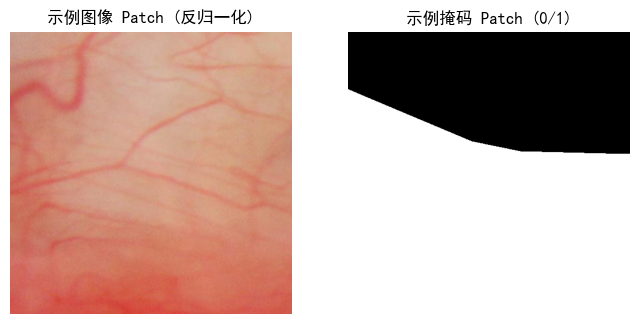

In [8]:
try:
    images_batch, masks_batch = next(iter(train_loader))
    print("\n从训练加载器获取一个批次的数据:")
    print(f"图像批次形状: {images_batch.shape}") # 应该类似 [BATCH_SIZE, 3, PATCH_SIZE, PATCH_SIZE]
    print(f"掩码批次形状: {masks_batch.shape}")   # 应该类似 [BATCH_SIZE, 1, PATCH_SIZE, PATCH_SIZE]
    print(f"图像数据类型: {images_batch.dtype}")
    print(f"掩码数据类型: {masks_batch.dtype}")
    print(f"掩码最小值: {masks_batch.min()}") # 应该是 0.0
    print(f"掩码最大值: {masks_batch.max()}") # 应该是 1.0
    
    # 可视化一个样本
    sample_idx = 0
    img_sample = images_batch[sample_idx].permute(1, 2, 0).numpy() # CHW -> HWC
    mask_sample = masks_batch[sample_idx].squeeze().numpy()       # 1HW -> HW
    
    # 反归一化以便显示
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_sample = std * img_sample + mean
    img_sample = np.clip(img_sample, 0, 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_sample)
    axes[0].set_title("示例图像 Patch (反归一化)")
    axes[0].axis('off')
    axes[1].imshow(mask_sample, cmap='gray')
    axes[1].set_title("示例掩码 Patch (0/1)")
    axes[1].axis('off')
    plt.show()

except StopIteration:
    print("错误：无法从 DataLoader 获取数据，请检查数据集是否为空或配置是否正确。")
except Exception as e:
    print(f"测试 DataLoader 时出错: {e}")

# 构建U-Net分割模型
U-Net是一种经典的图像分割模型，其结构包括下采样路径（编码器）和上采样路径（解码器），以及跳跃连接。

In [9]:
class DoubleConv(nn.Module):
    """双卷积块：(Conv -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """下采样层：MaxPool + DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """上采样层：UpConv + DoubleConv（带跳跃连接）"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # 使用双线性插值或转置卷积进行上采样
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 输入可能不是整数倍的2，需要进行尺寸调整
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # 连接特征图
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """输出卷积层"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """完整的UNet模型"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # 加载预训练的ResNet-18
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # 编码器部分 (使用ResNet-18的层)
        self.inc = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        ) # 输出通道: 64
        self.maxpool = resnet.maxpool
        self.down1 = resnet.layer1 # 输出通道: 64
        self.down2 = resnet.layer2 # 输出通道: 128
        self.down3 = resnet.layer3 # 输出通道: 256
        self.down4 = resnet.layer4 # 输出通道: 512

        # 解码器部分 (调整通道数以匹配ResNet)
        factor = 2 if bilinear else 1
        self.up1 = Up(512 + 256, 512 // factor, bilinear) # down4(512) + down3(256) -> 256
        self.up2 = Up(256 + 128, 256 // factor, bilinear) # up1(256) + down2(128) -> 128
        self.up3 = Up(128 + 64, 128 // factor, bilinear)  # up2(128) + down1(64) -> 64
        self.up4 = Up(64 + 64, 64, bilinear)             # up3(64) + inc(64) -> 64
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # 编码路径 (ResNet)
        x1 = self.inc(x)       # (N, 64, H/2, W/2) after initial conv+bn+relu (stride=2)
        x_pool = self.maxpool(x1) # (N, 64, H/4, W/4)
        x2 = self.down1(x_pool) # (N, 64, H/4, W/4)
        x3 = self.down2(x2)     # (N, 128, H/8, W/8)
        x4 = self.down3(x3)     # (N, 256, H/16, W/16)
        x5 = self.down4(x4)     # (N, 512, H/32, W/32)

        # 解码路径 (带跳跃连接)
        x = self.up1(x5, x4) # 输入: x5(512), x4(256) -> 输出: 256
        x = self.up2(x, x3)  # 输入: x(256), x3(128) -> 输出: 128
        x = self.up3(x, x2)  # 输入: x(128), x2(64) -> 输出: 64
        x = self.up4(x, x1)  # 输入: x(64), x1(64) -> 输出: 64
        logits = self.outc(x)
        return logits

# 初始化模型
model = UNet(n_classes=1, bilinear=True).to(device)
if torch.cuda.device_count() > 1:
    print(f"检测到 {torch.cuda.device_count()} 块GPU, 由于多卡存在问题，只使用GPU0")
    #model = nn.DataParallel(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


# 定义损失函数和评估指标
我们使用组合损失函数：二元交叉熵损失和Dice损失的组合，以更好地处理类别不平衡问题。

In [10]:
# Dice损失函数
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, logits, targets):
        # 使用sigmoid将logits转换为概率
        probs = torch.sigmoid(logits)
        
        # 将维度展平
        batch_size = targets.size(0)
        probs = probs.view(batch_size, -1)
        targets = targets.view(batch_size, -1)
        
        # 计算交集
        intersection = (probs * targets).sum(dim=1)
        
        # 计算Dice系数
        dice = (2. * intersection + self.smooth) / (
            probs.sum(dim=1) + targets.sum(dim=1) + self.smooth)
        
        # 返回Dice损失
        return 1 - dice.mean()

# 组合损失
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        # BCEWithLogitsLoss 实例本身不存储 pos_weight, 在 forward 中传入
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.dice_loss_fn = DiceLoss()

    def forward(self, logits, targets, pos_weight=None):
        """
        计算组合损失。
        :param logits: 模型输出 (N, 1, H, W)
        :param targets: 真实掩码 (N, 1, H, W)
        :param pos_weight: 正样本权重 (scalar) for BCE loss.
        """
        # 更新BCE损失的pos_weight参数
        self.bce_loss_fn.pos_weight = pos_weight
        bce = self.bce_loss_fn(logits, targets)

        dice = self.dice_loss_fn(logits, targets)
        return self.bce_weight * bce + self.dice_weight * dice

# 评估指标：Dice系数
def dice_coefficient(y_pred, y_true, threshold=0.5, smooth=1e-6):
    """计算预测掩码和真实掩码之间的Dice系数"""
    assert y_pred.shape == y_true.shape, f"预测形状 {y_pred.shape} 与目标形状 {y_true.shape} 不匹配"
    # 应用阈值将概率转换为二值掩码
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    
    # 压平张量
    y_pred = y_pred.contiguous().view(-1)
    y_true = y_true.contiguous().view(-1)
    
    # 计算交集
    intersection = (y_pred * y_true).sum()
    
    # 计算Dice系数
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)
    
    return dice.item()

# 初始化损失函数
criterion = CombinedLoss(bce_weight=0.6, dice_weight=0.4)

# 配置优化器和训练参数
设置Adam优化器和学习率调度器，为模型训练做准备。

In [11]:
# 训练参数
num_epochs = 30
log_interval = 5

# 配置优化器
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 学习率调度器
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6) # 使用基线超参数

# 训练模型
实现训练循环，包括前向传播、损失计算、反向传播、参数更新，并记录训练过程中的指标。同时实现早停机制。

In [12]:
# 定义早停类
from copy import deepcopy

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode
        self.best_model_weights = None
        
        # 根据模式确定比较操作
        if self.mode == 'min':
            self.delta_sign = -1  # 对于最小值模式，分数需要减少delta
        else:  # mode == 'max'
            self.delta_sign = 1  # 对于最大值模式，分数需要增加delta
    
    def __call__(self, val_score, model):
        score = val_score
        
        if self.best_score is None:
            self.best_score = score
            self.best_model_weights = deepcopy(model.state_dict())
            tqdm.write(f"EarlyStopping: 初始化最佳分数为 {self.best_score:.4f}")
        # 检查是否有足够的提升
        elif (score * self.delta_sign) > (self.best_score * self.delta_sign) + self.min_delta:
            # 有足够的提升
            self.best_score = score
            self.best_model_weights = deepcopy(model.state_dict())
            self.counter = 0
            tqdm.write(f"EarlyStopping: 发现改进。最佳分数更新为 {self.best_score:.4f}。计数器重置。")
        else:
            # 没有足够的提升
            self.counter += 1
            tqdm.write(f'EarlyStopping计数器: {self.counter} (共 {self.patience})。最佳分数仍为 {self.best_score:.4f}。')
            if self.counter >= self.patience:
                self.early_stop = True
                tqdm.write("EarlyStopping: 已达到耐心值。")

In [13]:
def train_validate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    """
    训练并验证模型一个完整的周期，支持早停和加权损失。
    返回：最佳验证Dice系数, 训练Dice历史, 验证Dice历史, 最佳模型state_dict
    """
    start_time = time.time()
    print("\n--- 开始训练 (使用 Patching 和 加权损失) ---")

    early_stopping = EarlyStopping(patience=7, mode='max', min_delta=0.001) # 可能需要调整patience和delta
    scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())
    train_dice_history = []
    val_dice_history = []
    best_model_state_dict = None
    best_val_dice = 0.0

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_samples = 0
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device) # images: (N, 3, P, P), masks: (N, 1, P, P)
            optimizer.zero_grad()

            # --- 计算 pos_weight ---
            num_pixels = masks.numel() # 总像素数 N*1*P*P
            num_pos = torch.sum(masks) # 正样本像素数
            num_neg = num_pixels - num_pos
            # 计算正样本权重 (避免除以0)
            pos_weight_value = num_neg / (num_pos + 1e-6)
            pos_weight_tensor = torch.tensor([pos_weight_value], device=device)

            # 使用混合精度训练
            with torch.amp.autocast('cuda'):
                outputs = model(images) # outputs: (N, 1, P, P)
                
                # 使用 'nearest' 插值以保持掩码的二值性
                masks_downsampled = torch.nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')
                # masks_downsampled 的形状现在是 (N, 1, 256, 256)
                loss = criterion(outputs, masks_downsampled, pos_weight=pos_weight_tensor) # 使用下采样后的掩码

            # 反向传播和优化
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_size = images.size(0)
            train_loss += loss.item() * batch_size
            train_dice += dice_coefficient(outputs, masks_downsampled) * batch_size
            train_samples += batch_size

            current_lr = optimizer.param_groups[0]['lr']
            train_loader_tqdm.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_coefficient(outputs, masks_downsampled):.4f}',
                'lr': f'{current_lr:.1e}',
                'pw': f'{pos_weight_value:.2f}' # 显示pos_weight
            })

        train_loss /= train_samples
        train_dice /= train_samples
        train_dice_history.append(train_dice)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_samples = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                # 验证时通常不计算加权损失，但如果计算，pos_weight也需计算
                # 这里我们仍然使用原始criterion计算损失值，但不传递pos_weight
                masks_downsampled = torch.nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')
                loss = criterion(outputs, masks_downsampled, pos_weight=None) # 或者传递计算出的pos_weight

                batch_size = images.size(0)
                val_loss += loss.item() * batch_size
                current_val_dice = dice_coefficient(outputs, masks_downsampled) # 计算当前批次的Dice
                val_dice += current_val_dice * batch_size
                val_samples += batch_size

        val_loss /= val_samples
        val_dice /= val_samples # 平均Dice
        val_dice_history.append(val_dice)

        # 更新学习率 (基于验证Dice)
        #scheduler.step(val_dice) # CosineAnnealingLR不需要参数，ReduceLROnPlateau需要
        scheduler.step()

        tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
                  f"Train Dice: {train_dice:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Val Dice: {val_dice:.4f}")

        # 早停检查
        if val_dice > best_val_dice + early_stopping.min_delta:
             best_val_dice = val_dice
             early_stopping.best_score = val_dice # 更新 early stopping 的 best_score
             early_stopping.best_model_weights = deepcopy(model.state_dict())
             early_stopping.counter = 0
             tqdm.write(f"EarlyStopping: 发现改进。最佳分数更新为 {best_val_dice:.4f}。计数器重置。")
        else:
            early_stopping.counter += 1
            tqdm.write(f'EarlyStopping计数器: {early_stopping.counter} (共 {early_stopping.patience})。最佳分数仍为 {best_val_dice:.4f}。')
            if early_stopping.counter >= early_stopping.patience:
                early_stopping.early_stop = True


        if early_stopping.early_stop:
            tqdm.write(f"早停触发于第 {epoch + 1} 轮。")
            best_model_state_dict = early_stopping.best_model_weights
            break

    # 如果训练正常完成，获取最佳权重
    if not early_stopping.early_stop and early_stopping.best_model_weights is not None:
        tqdm.write(f"训练在 {num_epochs} 轮后完成。")
        best_model_state_dict = early_stopping.best_model_weights
    elif early_stopping.best_model_weights is None and not early_stopping.early_stop:
        # Handle case where training finishes without improvement in the first epoch
        best_model_state_dict = deepcopy(model.state_dict())
        tqdm.write("训练完成，但未在验证集上观察到改进，保存最终模型。")


    # 使用最佳模型进行最终评估 (如果存在)
    final_val_dice = 0.0
    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict)
        model.eval()
        val_samples_final = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                masks_downsampled = torch.nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')
                batch_size = images.size(0)
                final_val_dice += dice_coefficient(outputs, masks_downsampled) * batch_size
                val_samples_final += batch_size
        if val_samples_final > 0:
            final_val_dice /= val_samples_final
        else:
            final_val_dice = 0.0 # Avoid division by zero
    else:
        tqdm.write("警告：无法获取最佳模型权重。最终Dice系数为0。")

    end_time = time.time()
    print("--- 训练完成 ---")
    print(f"最终(最佳)验证Dice系数: {final_val_dice:.4f}")
    print(f"训练耗时: {end_time - start_time:.2f} 秒")

    return final_val_dice, train_dice_history, val_dice_history, best_model_state_dict


# 开始训练
best_dice, train_dice_history, val_dice_history, best_model_weights = train_validate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler, # 如果是ReduceLROnPlateau, scheduler.step(val_dice)
    num_epochs=num_epochs,
    device=device
)


--- 开始训练 (使用 Patching 和 加权损失) ---


Epoch 1/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 0.3935, Train Dice: 0.8147, Val Loss: 0.5318, Val Dice: 0.7822
EarlyStopping: 发现改进。最佳分数更新为 0.7822。计数器重置。


Epoch 2/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [2/30], Train Loss: 0.3591, Train Dice: 0.8332, Val Loss: 0.4155, Val Dice: 0.8466
EarlyStopping: 发现改进。最佳分数更新为 0.8466。计数器重置。


Epoch 3/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [3/30], Train Loss: 0.3434, Train Dice: 0.8416, Val Loss: 0.4231, Val Dice: 0.8451
EarlyStopping计数器: 1 (共 7)。最佳分数仍为 0.8466。


Epoch 4/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [4/30], Train Loss: 0.3335, Train Dice: 0.8471, Val Loss: 0.5066, Val Dice: 0.7927
EarlyStopping计数器: 2 (共 7)。最佳分数仍为 0.8466。


Epoch 5/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [5/30], Train Loss: 0.3156, Train Dice: 0.8559, Val Loss: 0.4978, Val Dice: 0.7541
EarlyStopping计数器: 3 (共 7)。最佳分数仍为 0.8466。


Epoch 6/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [6/30], Train Loss: 0.3065, Train Dice: 0.8596, Val Loss: 0.4112, Val Dice: 0.8436
EarlyStopping计数器: 4 (共 7)。最佳分数仍为 0.8466。


Epoch 7/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [7/30], Train Loss: 0.2932, Train Dice: 0.8664, Val Loss: 0.4714, Val Dice: 0.8032
EarlyStopping计数器: 5 (共 7)。最佳分数仍为 0.8466。


Epoch 8/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [8/30], Train Loss: 0.2843, Train Dice: 0.8713, Val Loss: 0.3427, Val Dice: 0.8709
EarlyStopping: 发现改进。最佳分数更新为 0.8709。计数器重置。


Epoch 9/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [9/30], Train Loss: 0.2747, Train Dice: 0.8753, Val Loss: 0.3885, Val Dice: 0.8460
EarlyStopping计数器: 1 (共 7)。最佳分数仍为 0.8709。


Epoch 10/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 0.2674, Train Dice: 0.8791, Val Loss: 0.3507, Val Dice: 0.8652
EarlyStopping计数器: 2 (共 7)。最佳分数仍为 0.8709。


Epoch 11/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [11/30], Train Loss: 0.2582, Train Dice: 0.8843, Val Loss: 0.3217, Val Dice: 0.8842
EarlyStopping: 发现改进。最佳分数更新为 0.8842。计数器重置。


Epoch 12/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [12/30], Train Loss: 0.2473, Train Dice: 0.8897, Val Loss: 0.3309, Val Dice: 0.8818
EarlyStopping计数器: 1 (共 7)。最佳分数仍为 0.8842。


Epoch 13/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [13/30], Train Loss: 0.2399, Train Dice: 0.8925, Val Loss: 0.3188, Val Dice: 0.8842
EarlyStopping计数器: 2 (共 7)。最佳分数仍为 0.8842。


Epoch 14/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [14/30], Train Loss: 0.2250, Train Dice: 0.8999, Val Loss: 0.2880, Val Dice: 0.8961
EarlyStopping: 发现改进。最佳分数更新为 0.8961。计数器重置。


Epoch 15/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [15/30], Train Loss: 0.2150, Train Dice: 0.9048, Val Loss: 0.2828, Val Dice: 0.8972
EarlyStopping: 发现改进。最佳分数更新为 0.8972。计数器重置。


Epoch 16/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [16/30], Train Loss: 0.1998, Train Dice: 0.9125, Val Loss: 0.2553, Val Dice: 0.9112
EarlyStopping: 发现改进。最佳分数更新为 0.9112。计数器重置。


Epoch 17/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [17/30], Train Loss: 0.1814, Train Dice: 0.9222, Val Loss: 0.2430, Val Dice: 0.9157
EarlyStopping: 发现改进。最佳分数更新为 0.9157。计数器重置。


Epoch 18/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [18/30], Train Loss: 0.1640, Train Dice: 0.9312, Val Loss: 0.2535, Val Dice: 0.9122
EarlyStopping计数器: 1 (共 7)。最佳分数仍为 0.9157。


Epoch 19/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [19/30], Train Loss: 0.1475, Train Dice: 0.9396, Val Loss: 0.3134, Val Dice: 0.8929
EarlyStopping计数器: 2 (共 7)。最佳分数仍为 0.9157。


Epoch 20/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [20/30], Train Loss: 0.1315, Train Dice: 0.9472, Val Loss: 0.1983, Val Dice: 0.9366
EarlyStopping: 发现改进。最佳分数更新为 0.9366。计数器重置。


Epoch 21/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [21/30], Train Loss: 0.1176, Train Dice: 0.9539, Val Loss: 0.1895, Val Dice: 0.9401
EarlyStopping: 发现改进。最佳分数更新为 0.9401。计数器重置。


Epoch 22/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [22/30], Train Loss: 0.1040, Train Dice: 0.9606, Val Loss: 0.1931, Val Dice: 0.9407
EarlyStopping计数器: 1 (共 7)。最佳分数仍为 0.9401。


Epoch 23/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [23/30], Train Loss: 0.0942, Train Dice: 0.9648, Val Loss: 0.1695, Val Dice: 0.9484
EarlyStopping: 发现改进。最佳分数更新为 0.9484。计数器重置。


Epoch 24/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [24/30], Train Loss: 0.0846, Train Dice: 0.9689, Val Loss: 0.1705, Val Dice: 0.9505
EarlyStopping: 发现改进。最佳分数更新为 0.9505。计数器重置。


Epoch 25/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [25/30], Train Loss: 0.0785, Train Dice: 0.9712, Val Loss: 0.1591, Val Dice: 0.9539
EarlyStopping: 发现改进。最佳分数更新为 0.9539。计数器重置。


Epoch 26/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [26/30], Train Loss: 0.0728, Train Dice: 0.9733, Val Loss: 0.1589, Val Dice: 0.9547
EarlyStopping计数器: 1 (共 7)。最佳分数仍为 0.9539。


Epoch 27/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [27/30], Train Loss: 0.0688, Train Dice: 0.9748, Val Loss: 0.1561, Val Dice: 0.9557
EarlyStopping: 发现改进。最佳分数更新为 0.9557。计数器重置。


Epoch 28/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [28/30], Train Loss: 0.0652, Train Dice: 0.9761, Val Loss: 0.1534, Val Dice: 0.9567
EarlyStopping: 发现改进。最佳分数更新为 0.9567。计数器重置。


Epoch 29/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [29/30], Train Loss: 0.0632, Train Dice: 0.9768, Val Loss: 0.1500, Val Dice: 0.9576
EarlyStopping计数器: 1 (共 7)。最佳分数仍为 0.9567。


Epoch 30/30:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch [30/30], Train Loss: 0.0619, Train Dice: 0.9772, Val Loss: 0.1504, Val Dice: 0.9574
EarlyStopping计数器: 2 (共 7)。最佳分数仍为 0.9567。
训练在 30 轮后完成。
--- 训练完成 ---
最终(最佳)验证Dice系数: 0.9567
训练耗时: 10910.10 秒


# 评估模型性能
可视化学习曲线和分割结果，计算Dice系数和95% Hausdorff距离等评估指标。

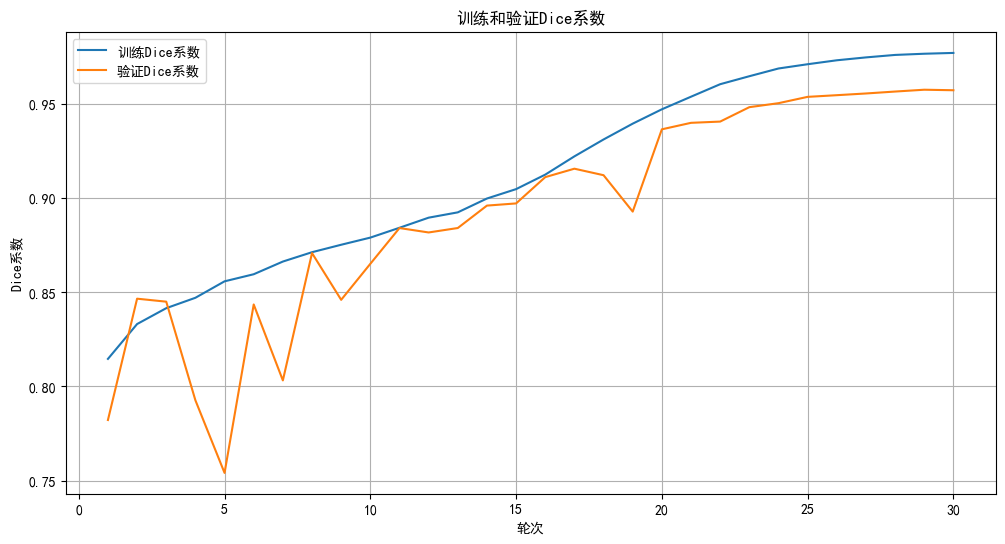

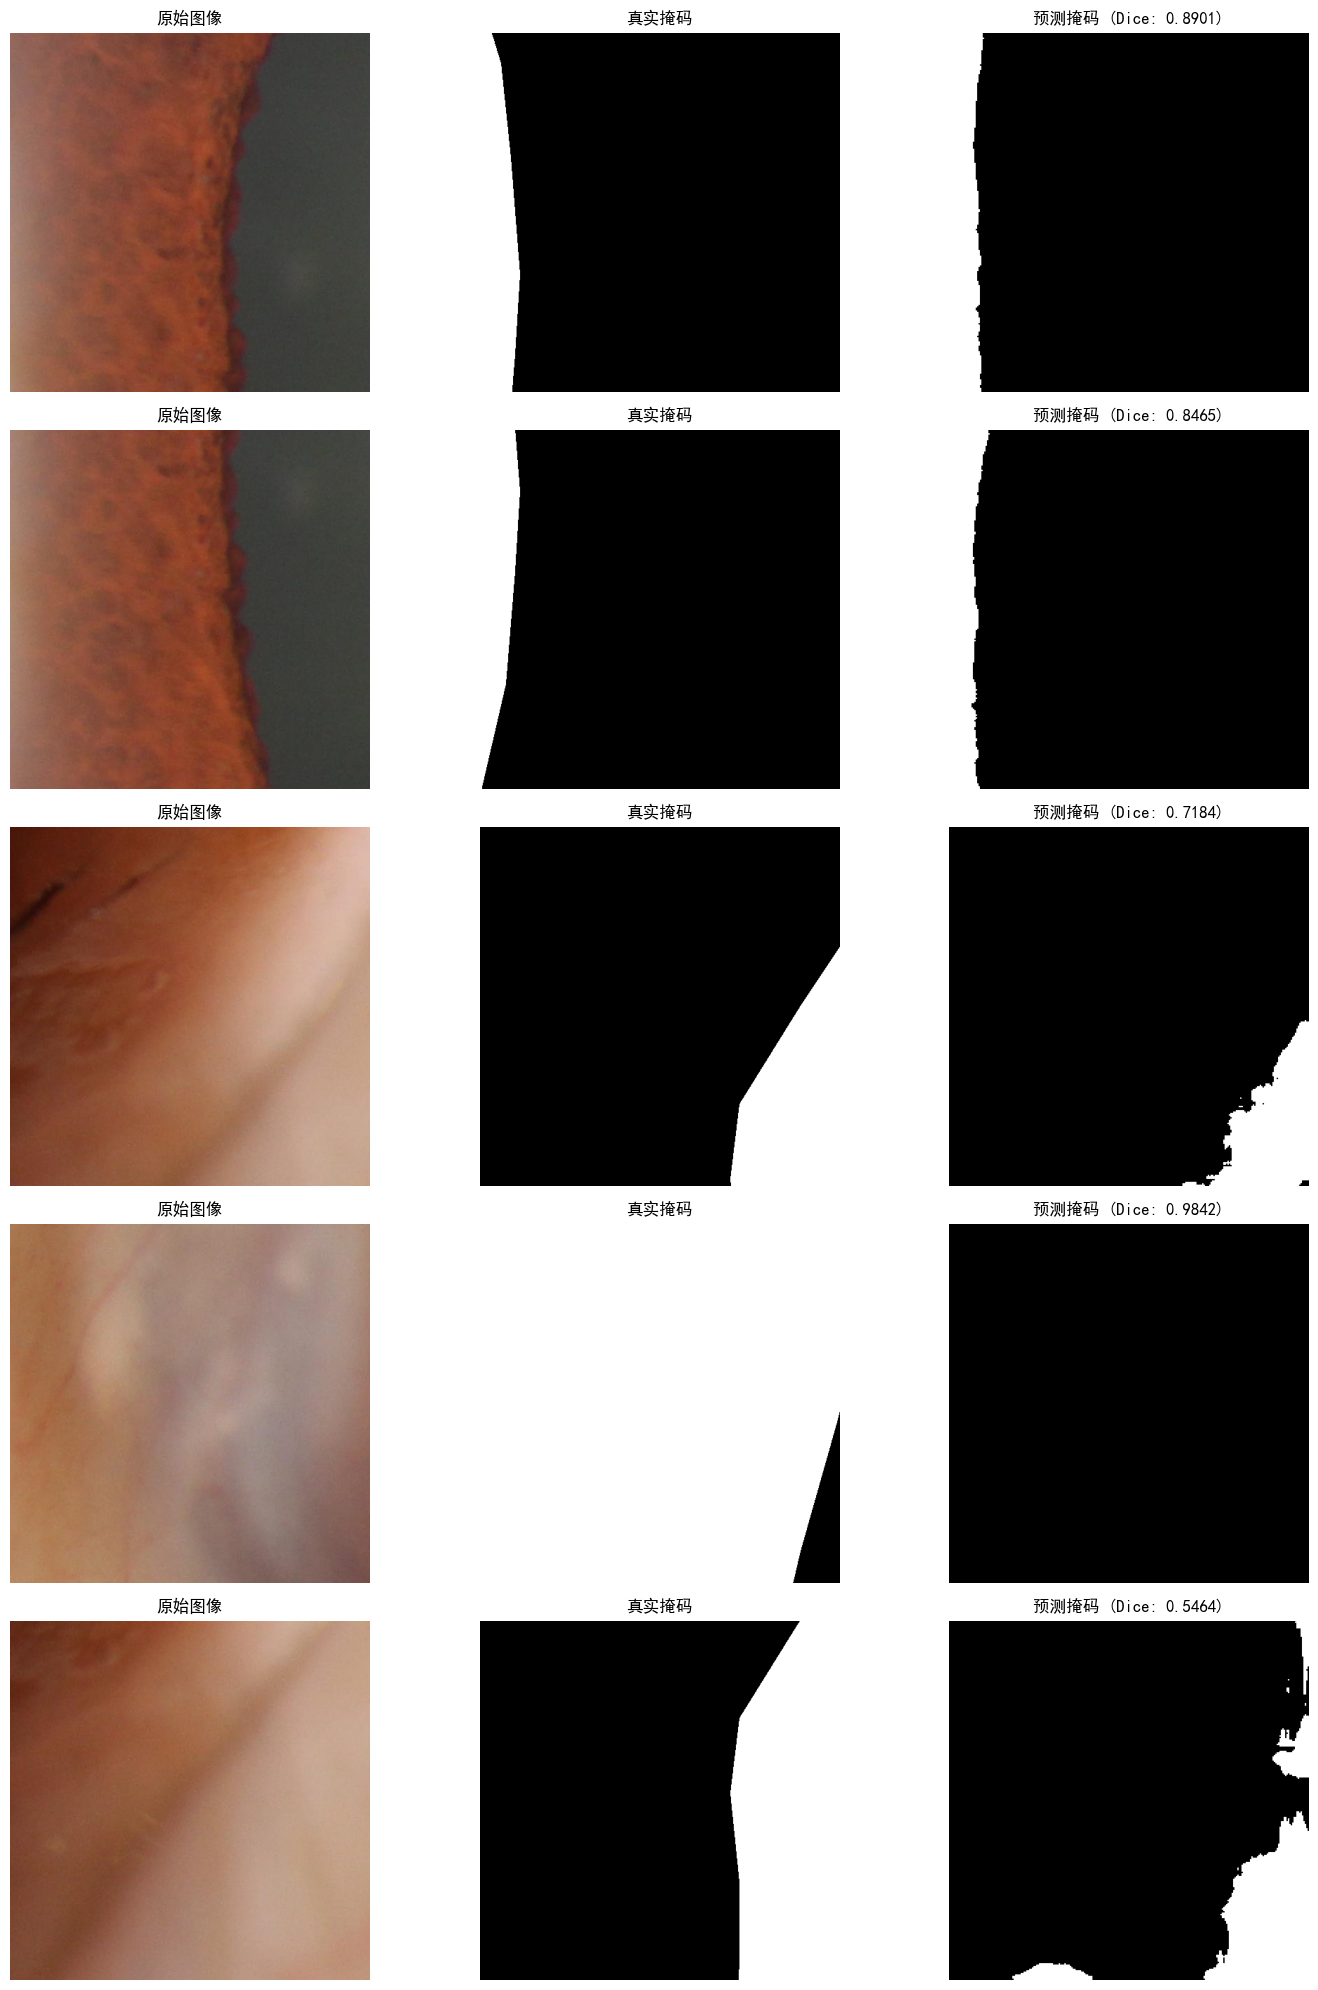

In [14]:
# 可视化学习曲线
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_dice_history) + 1), train_dice_history, label='训练Dice系数')
plt.plot(range(1, len(val_dice_history) + 1), val_dice_history, label='验证Dice系数')
plt.title('训练和验证Dice系数')
plt.xlabel('轮次')
plt.ylabel('Dice系数')
plt.legend()
plt.grid(True)
plt.show()

# 可视化分割结果
def visualize_segmentation(model, dataloader, num_samples=5):
    """可视化分割结果"""
    model.eval()
    dataiter = iter(dataloader)
    
    # 获取一批数据
    try:
        images, masks = next(dataiter)
    except StopIteration:
        print("数据集太小，无法获取足够的样本。")
        return
    
    # 限制样本数
    num_samples = min(num_samples, images.size(0))
    
    # 进行预测
    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        pred_masks = (torch.sigmoid(outputs) > 0.5).float()
    
    # 反标准化图像以便可视化
    images_np = []
    for img in images[:num_samples]:
        img = img.cpu().numpy().transpose(1, 2, 0)  # 转为HWC格式
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        images_np.append(img)
    
    # 准备掩码和预测
    masks_np = masks[:num_samples].cpu().numpy().squeeze(1)  # (N, H, W)
    pred_masks_np = pred_masks[:num_samples].cpu().numpy().squeeze(1)  # (N, H, W)
    
    # 可视化
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
    
    for i in range(num_samples):
        # 原始图像
        axes[i, 0].imshow(images_np[i])
        axes[i, 0].set_title('原始图像')
        axes[i, 0].axis('off')
        
        # 真实掩码
        axes[i, 1].imshow(masks_np[i], cmap='gray')
        axes[i, 1].set_title('真实掩码')
        axes[i, 1].axis('off')
        
        # 预测掩码
        axes[i, 2].imshow(pred_masks_np[i], cmap='gray')
        masks_downsampled = torch.nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')
        dice = dice_coefficient(outputs[i:i+1], masks_downsampled[i:i+1])
        axes[i, 2].set_title(f'预测掩码 (Dice: {dice:.4f})')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_segmentation(model, val_loader, num_samples=5) # 可视化验证集(resize后)的结果

# 模型保存和加载
保存训练好的模型，以便将来加载并用于预测。

In [15]:
# 保存模型参数

def save_model(model, path):
    """保存模型参数到指定路径"""
    torch.save(model.state_dict(), path)
    print(f"模型参数已保存到 {path}")
save_model_path=f'/kaggle/working/work2model_dice-{best_dice}_{time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime())}.pth'
save_model(model,save_model_path)

模型参数已保存到 /kaggle/working/work2model_dice-0.9566780462556955_2025-04-13-07:10:38.pth


# 模型预测与应用

遍历测试图像，加载它们，进行预处理，然后使用加载的模型进行预测，最后将预测的掩码保存下来。

In [16]:
# --- 1. 加载训练好的模型 ---

try:
    model_save_path = save_model_path
except:
    print("model_save_path 未定义。请确保在训练后保存模型。")

loaded_model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
# 加载最佳权重 (假设 best_model_weights 变量包含 state_dict)
if 'best_model_weights' in locals() and best_model_weights is not None:
    loaded_model.load_state_dict(best_model_weights)
    print("成功加载训练好的模型权重。")
else:
    # 如果没有 best_model_weights，尝试从文件加载（需要先保存）
    if os.path.exists(model_save_path):
        loaded_model.load_state_dict(torch.load(model_save_path, map_location=device, weights_only=True))
        print(f"从 {model_save_path} 加载模型权重。")
    else:
        print("警告: 未找到训练好的模型权重 (best_model_weights 或文件)。模型将使用随机初始化的权重。")

loaded_model.eval(); # 设置为评估模式

成功加载训练好的模型权重。


In [17]:
# --- 2. 定义 Tiling 预测函数 ---
def predict_with_tiling(model, image_path, patch_size, stride, device, batch_size=4, threshold=0.5):
    """
    使用 Tiling 和重叠平均策略预测大图的掩码。
    :param model: 训练好的模型
    :param image_path: 原始大图路径
    :param patch_size: patch 大小 (int)
    :param stride: 切割 patch 时的步长 (int)
    :param device: 设备
    :param batch_size: 推理时的批次大小
    :param threshold: 二值化阈值
    :return: 预测的二值掩码 (numpy array, H x W) 或 None
    """
    try:
        img = Image.open(image_path).convert('RGB')
        img_w, img_h = img.size
    except FileNotFoundError:
        print(f"错误: 图像文件未找到 {image_path}")
        return None
    except Exception as e:
        print(f"错误: 加载图像时出错 {image_path}: {e}")
        return None

    model.eval() # 确保模型在评估模式

    # 定义预处理 (仅 ToTensor 和 Normalize)
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 计算所需的 padding
    pad_h = max(patch_size - img_h, 0)
    pad_w = max(patch_size - img_w, 0)
    # 在右侧和底部进行 padding，使其尺寸至少为 patch_size
    # 进一步 padding 使尺寸能被 stride 整除，以便覆盖所有边缘
    target_h = img_h + pad_h
    target_w = img_w + pad_w
    pad_h_stride = (stride - (target_h - patch_size) % stride) % stride
    pad_w_stride = (stride - (target_w - patch_size) % stride) % stride

    padding = (0, 0, pad_w + pad_w_stride, pad_h + pad_h_stride) # (left, top, right, bottom)
    img_padded = F.pad(img, padding, padding_mode='reflect') # 使用反射填充
    padded_h, padded_w = img_padded.size[1], img_padded.size[0] # PIL size is W, H

    # 创建空的概率图和计数图
    pred_prob_map = torch.zeros((1, padded_h, padded_w), dtype=torch.float32, device=device)
    count_map = torch.zeros((1, padded_h, padded_w), dtype=torch.float32, device=device)

    # 收集所有 patch 的坐标
    patch_coords = []
    for y in range(0, padded_h - patch_size + 1, stride):
        for x in range(0, padded_w - patch_size + 1, stride):
            patch_coords.append((x, y))

    # 分批处理 patches
    with torch.no_grad():
        for i in tqdm(range(0, len(patch_coords), batch_size), desc="Tiling Prediction",leave=False):
            batch_coords = patch_coords[i:i+batch_size]
            batch_patches_pil = [img_padded.crop((x, y, x + patch_size, y + patch_size)) for x, y in batch_coords]
            batch_patches_tensor = torch.stack([preprocess(p) for p in batch_patches_pil]).to(device)

            # 模型预测 (输出 logits)
            batch_outputs_logits = model(batch_patches_tensor)
            batch_outputs_probs = torch.sigmoid(batch_outputs_logits) # (B, 1, P, P)

            # 将预测结果累加回概率图
            for j, (x, y) in enumerate(batch_coords):
                # 修复：将模型输出上采样到patch_size大小
                output_height, output_width = batch_outputs_probs[j].shape[1:] # 获取当前输出尺寸
                if output_height != patch_size or output_width != patch_size:
                    # 上采样到与patch相同大小
                    upsampled_output = torch.nn.functional.interpolate(
                        batch_outputs_probs[j].unsqueeze(0), # 增加批次维度
                        size=(patch_size, patch_size),
                        mode='bilinear',
                        align_corners=False
                    ).squeeze(0) # 移除批次维度
                    pred_prob_map[:, y:y+patch_size, x:x+patch_size] += upsampled_output
                else:
                    pred_prob_map[:, y:y+patch_size, x:x+patch_size] += batch_outputs_probs[j]
                count_map[:, y:y+patch_size, x:x+patch_size] += 1

    # 处理计数为0的区域（如果padding策略完美，不应出现，但以防万一）
    count_map[count_map == 0] = 1
    # 计算平均概率
    avg_prob_map = pred_prob_map / count_map

    # 裁剪回原始图像尺寸 (去掉 padding)
    original_h, original_w = img_h, img_w
    avg_prob_map_cropped = avg_prob_map[:, :original_h, :original_w]

    # 应用阈值得到最终二值掩码
    final_mask = (avg_prob_map_cropped > threshold).squeeze().cpu().numpy().astype(np.uint8)

    # --- 后处理：保留最大连通区域 ---
    if np.sum(final_mask) > 0: # 检查是否有任何前景像素
        # 标记连通区域 (背景为0)
        labeled_mask = label(final_mask)
        
        # 计算每个区域的面积 (忽略背景区域0)
        region_props = np.unique(labeled_mask[labeled_mask > 0], return_counts=True)
        
        if len(region_props[0]) > 0: # 确保至少有一个前景区域
            # 找到最大区域的标签
            largest_component_label = region_props[0][np.argmax(region_props[1])]
            
            # 创建只包含最大区域的新掩码
            final_mask_processed = np.zeros_like(final_mask)
            final_mask_processed[labeled_mask == largest_component_label] = 1
            final_mask = final_mask_processed # 用处理后的掩码替换原掩码
        else:
            # 如果 labeled_mask > 0 为空（理论上不应在 np.sum > 0 后发生，但做个健壮性检查）
            final_mask = np.zeros_like(final_mask) # 无前景区域，返回空掩码
    else:
        # 如果原始掩码全为0，则保持全零
        pass 
    # --- 后处理结束 ---

    return final_mask

找到 150 张待预测图像于 /kaggle/input/pterygium/val_img/val_img


处理预测图像:   0%|          | 0/150 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

Tiling Prediction:   0%|          | 0/9 [00:00<?, ?it/s]


可视化 10 个预测结果...


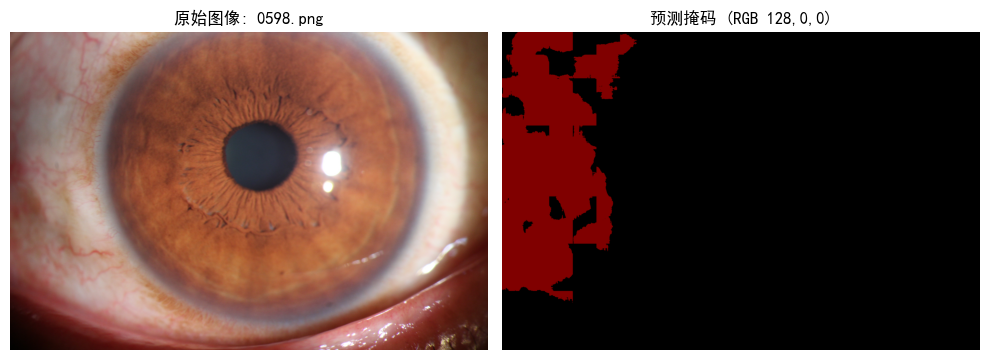

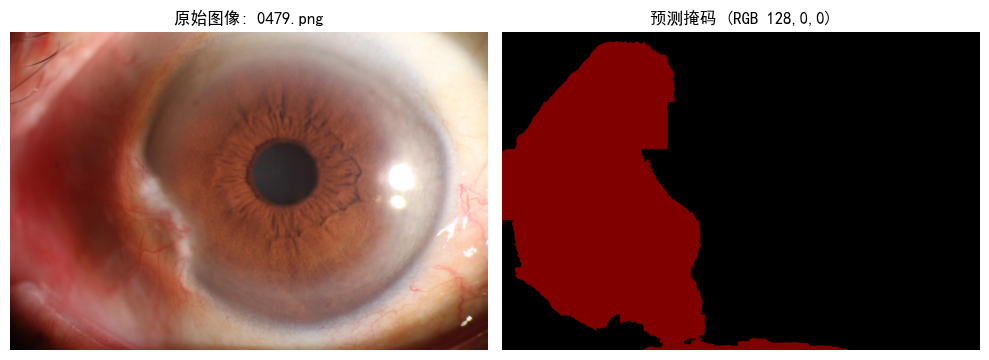

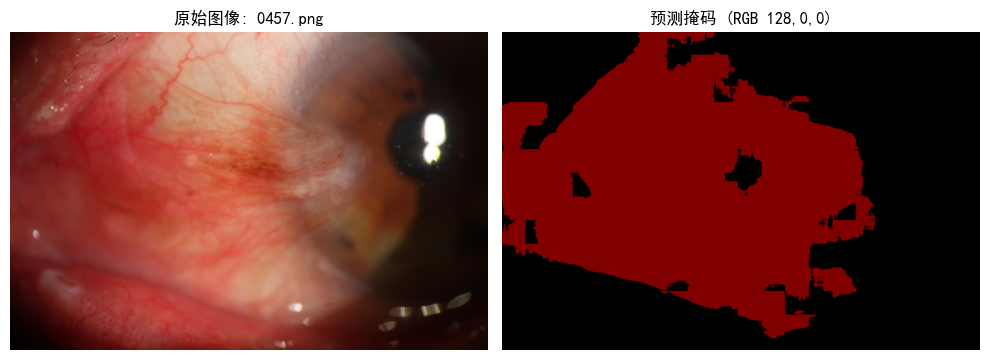

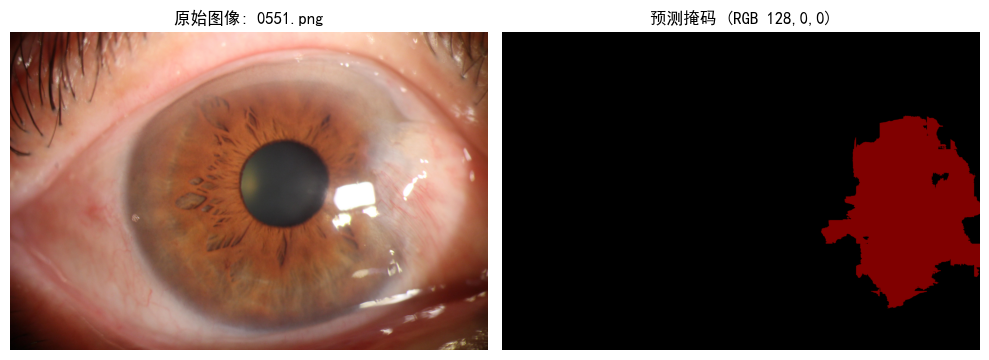

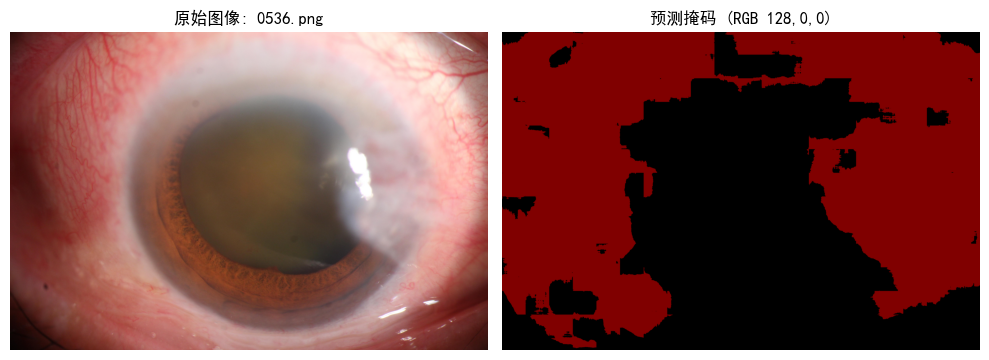

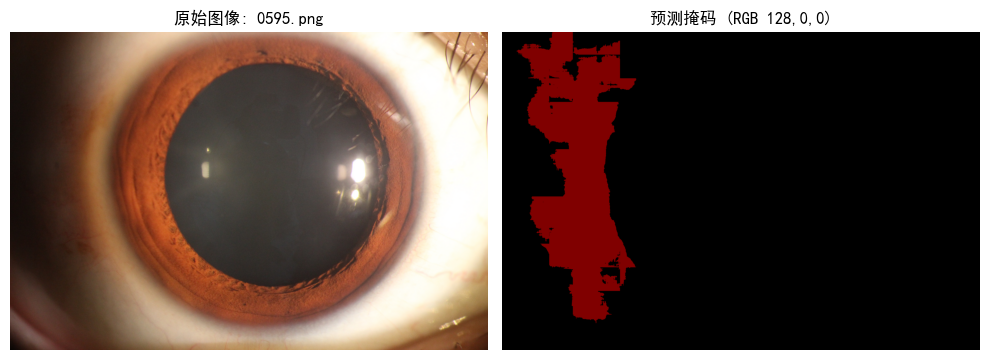

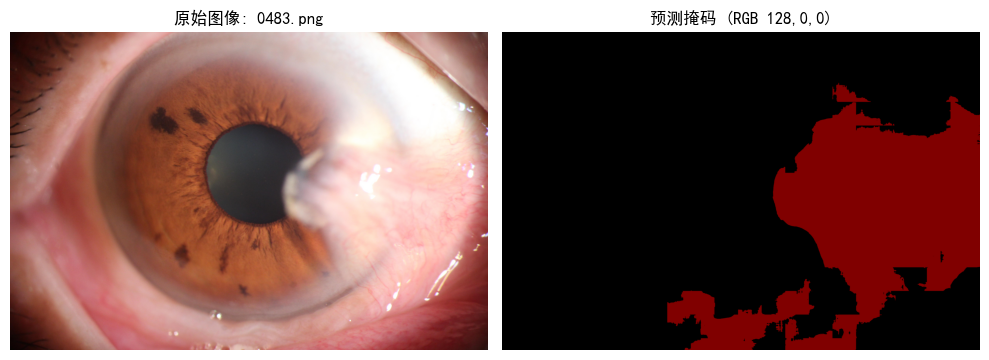

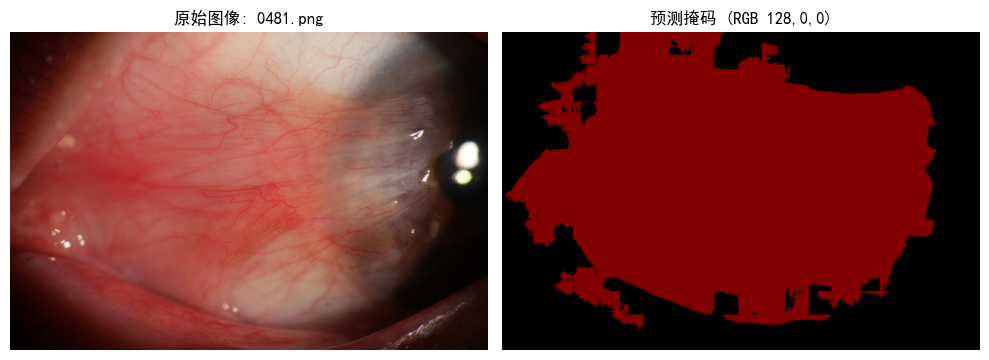

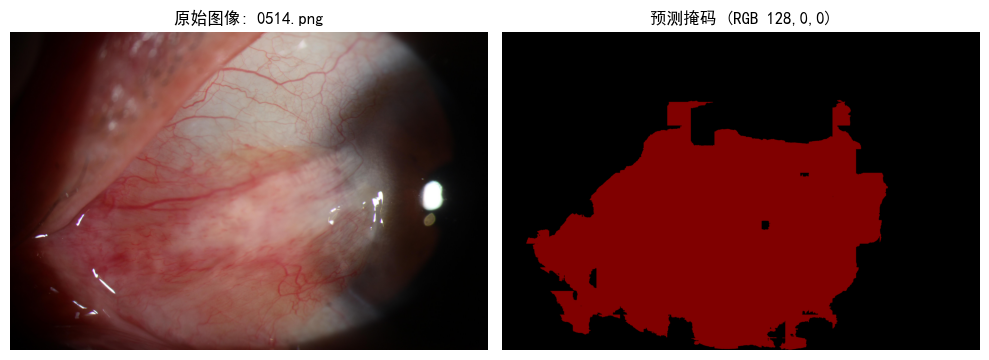

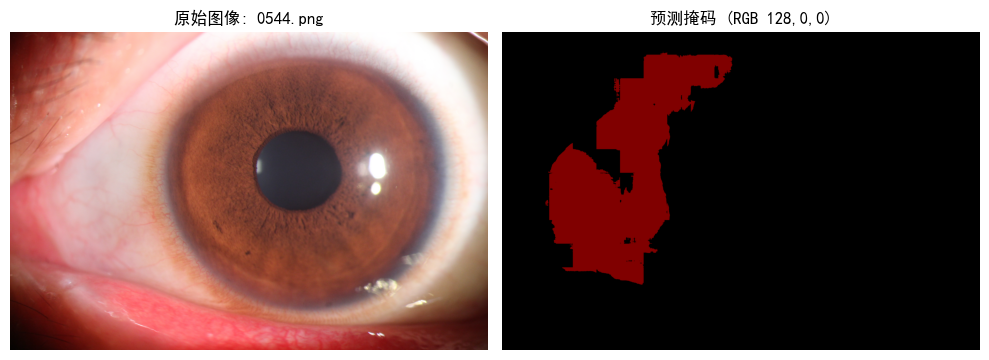

In [18]:
# --- 3. 对测试图像进行预测 ---

# 输出预测掩码的目录
if os.path.exists(output_mask_dir):
    print(f"输出目录 {output_mask_dir} 已存在，删除旧目录。")
    import shutil
    shutil.rmtree(output_mask_dir)
os.makedirs(output_mask_dir, exist_ok=True)

# 查找所有测试图像
test_image_paths = glob.glob(os.path.join(val_image_dir, "*.png"))

print(f"找到 {len(test_image_paths)} 张待预测图像于 {val_image_dir}")

# 遍历测试图像并进行预测
for img_path in tqdm(test_image_paths, desc="处理预测图像"):
    # 使用 Tiling 进行预测
    predicted_mask_np = predict_with_tiling(
        model=loaded_model,
        image_path=img_path,
        patch_size=patch_size,
        stride=predict_stride, # 使用之前定义的 stride
        device=device,
        batch_size=32 # 可以根据GPU内存调整
    )

    if predicted_mask_np is not None:
        # predicted_mask_np 是 (H, W) 的 numpy 数组，值为 0 或 1
        # 创建RGB掩码图像，前景(1)为(128,0,0)，背景(0)为(0,0,0)
        h, w = predicted_mask_np.shape
        rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
        # 设置前景区域(值为1的位置)为(128,0,0)
        rgb_mask[predicted_mask_np == 1, 0] = 128  # R通道设为128
        # 背景区域(值为0的位置)默认已经是(0,0,0)
        mask_image = Image.fromarray(rgb_mask, mode='RGB')

        base_name = os.path.basename(img_path)
        save_name = f"{os.path.splitext(base_name)[0]}.png" # 统一保存为png
        save_path = os.path.join(output_mask_dir, save_name)

        try:
            mask_image.save(save_path)
            # print(f"预测掩码已保存到: {save_path}")
        except Exception as e:
            print(f"保存掩码时出错 {save_path}: {e}")

# 可视化结果
# 要可视化的样本数量
num_visualize = 10
if not test_image_paths:
    print("错误：找不到测试图像路径，无法进行可视化。")
else:
    # 确保样本数量不超过实际图像数量
    num_visualize = min(num_visualize, len(test_image_paths))
    if num_visualize > 0:
        # 随机选择图像路径进行可视化
        sample_paths = random.sample(test_image_paths, num_visualize)
        print(f"\n可视化 {num_visualize} 个预测结果...")

        for img_path in sample_paths:
            try:
                # 加载原始图像
                original_image = Image.open(img_path).convert('RGB')

                # 构建对应的预测掩码文件的路径
                base_name = os.path.basename(img_path)
                file_stem = os.path.splitext(base_name)[0]
                mask_filename = f"{file_stem}.png" # 假设保存的掩码文件名与原图名相同
                predicted_mask_path = os.path.join(output_mask_dir, mask_filename)

                # 检查预测掩码文件是否存在并加载
                if os.path.exists(predicted_mask_path):
                    predicted_mask_image = Image.open(predicted_mask_path) # 加载之前保存的RGB掩码

                    # 创建绘图
                    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                    # 显示原始图像
                    axes[0].imshow(original_image)
                    axes[0].set_title(f"原始图像: {base_name}")
                    axes[0].axis('off')

                    # 显示对应的预测掩码
                    axes[1].imshow(predicted_mask_image) # 显示加载的对应掩码
                    axes[1].set_title("预测掩码 (RGB 128,0,0)")
                    axes[1].axis('off')

                    plt.tight_layout() # 调整布局防止重叠
                    plt.show()
                else:
                    print(f"警告：找不到预测掩码文件 {predicted_mask_path}，无法可视化此样本。")

            except Exception as e:
                print(f"可视化图像 {img_path} 时出错: {e}")
    else:
        print("没有测试图像可供可视化。")

In [19]:
# --- 4. 压缩结果 ---
if 'google.colab' in sys.modules or os.path.exists("/kaggle/working"):
    zip_file_path = f"{output_mask_dir}.zip"

    if output_mask_dir and os.path.exists(output_mask_dir) and os.listdir(output_mask_dir):
        print(f"开始压缩目录: {output_mask_dir}")
        try:
            with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
                files_to_zip = glob.glob(os.path.join(output_mask_dir, '*.*'))
                if not files_to_zip:
                    print(f"警告: 目录 {output_mask_dir} 为空，无需压缩。")
                else:
                    for file in tqdm(files_to_zip, desc="压缩文件"):
                        zipf.write(file, arcname=os.path.basename(file))
                    print(f"预测结果已成功压缩到: {zip_file_path}")

                    # 删除原始文件和目录 (可选)
                    print(f"删除原始掩码文件于: {output_mask_dir}")
                    import shutil
                    shutil.rmtree(output_mask_dir)

        except Exception as e:
            print(f"压缩或删除文件时发生错误: {e}")
    elif output_mask_dir:
        print(f"目录 {output_mask_dir} 不存在或为空，跳过压缩和删除步骤。")


print("\n预测处理完成。")

开始压缩目录: /kaggle/working/mask


压缩文件:   0%|          | 0/150 [00:00<?, ?it/s]

预测结果已成功压缩到: /kaggle/working/mask.zip
删除原始掩码文件于: /kaggle/working/mask

预测处理完成。
